
# **GMDL - Final Project**

Submission:
- Daniel Adam, ID: 342475639

# **0. Packages**

In [ ]:
import os
import torch

# Datasets
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import MNIST, CIFAR10
from project_utils import CombinedDataset

# For downloading trained models
from google.colab import files

# Trainings
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time

# Plots
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Metrices
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, auc

# **1. Data Preparation**

In [ ]:
# Data augmentation and transformation for MNIST
mnist_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(10),  # Randomly rotate the images by 10 degrees
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalization with MNIST stats
])

# Data augmentation and transformation for CIFAR-10
cifar_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(10),  # Randomly rotate the images by 10 degrees
    transforms.Grayscale(num_output_channels=1),  # Convert CIFAR-10 to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize CIFAR-10 similarly
])

# Load MNIST dataset with train/test splits
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)


# Split MNIST training data into training and validation sets
train_size = int(0.8 * len(mnist_train)) # take 80% of the train set for training and 20% for validation for the loss threshold of AE
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

# Create data loaders for MNIST train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Load the CIFAR-10 dataset as the OOD dataset
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)

# Use a subset of 1000 OOD samples
ood_subset = torch.utils.data.Subset(cifar10_test, list(range(1000)))

# Combine the MNIST test set with the OOD samples for OSR evaluation

# MNIST labels are set to 0, and CIFAR-10 labels are set to 1
combined_ds = CombinedDataset(mnist_test, ood_subset)
data_loader = DataLoader(combined_ds, batch_size=1024, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 9627080.32it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2009650.34it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13024620.98it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8193775.81it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 170498071/170498071 [00:02<00:00, 70656655.19it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


# **2. Model Development**

**3.1 Baseline Model**

In [ ]:
class CNNDigitClassifier(nn.Module):
    def __init__(self):
        super(CNNDigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for digits 0-9

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        embeddings = x
        outputs = self.fc2(x)
        return outputs, embeddings


**3.2 Auto Encoder**

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh() # TanH instead of sigmoid because values in [-1,1] are possible and not only [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

**3.3 OSR Model**

In [ ]:
class OSR_Model(nn.Module):
  def __init__(self, cnn_model, autoencoder):
    super(OSR_Model, self).__init__()
    self.cnn_model = cnn_model
    self.autoencoder = autoencoder

  def get_baseline_model(self):
    return self.cnn_model

  def get_autoencoder(self):
    return self.autoencoder

# **3. Model State Definition**

In [ ]:
is_training = True

*** !! If is_training = True -> drop the two model weights files provided in the ZIP file to Files here in the content of this notebook!! ***

In [ ]:
trained_models_dir = '/content/'
os.makedirs(trained_models_dir, exist_ok=True)
baseline_model_path = os.path.join(trained_models_dir, "baseline_model_weights.pth")
autoencoder_path = os.path.join(trained_models_dir, "autoencoder_weights.pth")

# **4. Training**

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, epochs):
    model.train()
    loss_history = []  # List to store loss values for plotting

    for epoch in range(epochs):
        running_loss = 0.0  
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)  # Move data and labels to the specified device (CPU/GPU)

            optimizer.zero_grad()  # Clear gradients of all optimized tensors
            outputs, _ = model(data)  # Perform a forward pass through the model
            loss = criterion(outputs, labels)  # Compute the loss between predictions and true labels
            loss.backward()  # Backpropagate the gradients to the model's parameters
            optimizer.step()  # Update parameters based on the computed gradients

            running_loss += loss.item()  # Accumulate the loss for this batch

        # Calculate the average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)  # Store the average loss for this epoch

    # Plot the training loss curve over epochs
    plt.figure()
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss of Baseline Model')
    plt.legend()
    plt.show()
    
    # Print the final trained model structure
    print(f'This is the trained Baseline Model:\n{model}\n')


In [ ]:
def train_autoencoder(model, train_loader, criterion, optimizer, device, epochs):
    model.train()  
    loss_history = [] 

    for epoch in range(epochs):
        running_loss = 0.0  
        for data, _ in train_loader:
            data = data.to(device)  # Move data to the specified device (CPU/GPU)

            optimizer.zero_grad()  # Clear the gradients of all optimized tensors
            outputs = model(data)  # Perform a forward pass through the autoencoder
            loss = criterion(outputs, data)  # Compute the reconstruction loss between the output and input
            loss.backward()  # Backpropagate the gradients to the model's parameters
            optimizer.step()  # Update parameters based on the computed gradients

            running_loss += loss.item()  # Accumulate the loss for this batch

        # Calculate the average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)  # Store the average loss for this epoch

    # Plot the training loss curve over epochs
    plt.figure()
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss of AE')
    plt.legend()
    plt.show()
    
    # Print the final trained autoencoder model structure
    print(f'This is the trained Auto Encoder:\n{model}\n')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Initialize Baseline Model and Auto Encoder
baseline_model = CNNDigitClassifier().to(device)
autoencoder = Autoencoder().to(device)

**4.1 Train Baseline Model**

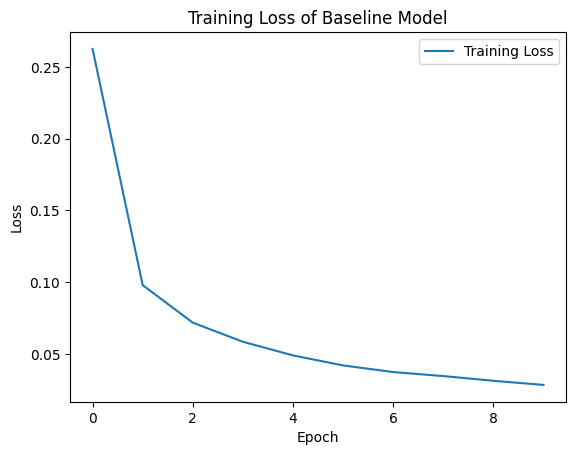

This is the trained Baseline Model:
CNNDigitClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)



In [ ]:
# Conditional model training
if is_training:
  # Load the baseline model
  baseline_model.load_state_dict(torch.load(baseline_model_path, map_location=device))

else:
  optimizer_cnn = optim.Adam(baseline_model.parameters(), lr=0.001)
  criterion_cnn = nn.CrossEntropyLoss()

  train_model(baseline_model, train_loader, criterion_cnn, optimizer_cnn, device, epochs=10)


***Tranining of the baseline model converges***

In [ ]:
# Model converged with a good loss -> save and download the model
if not is_training:
  torch.save(baseline_model.state_dict(), baseline_model_path)
  files.download(baseline_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**4.2 Train Auto Encoder Model**

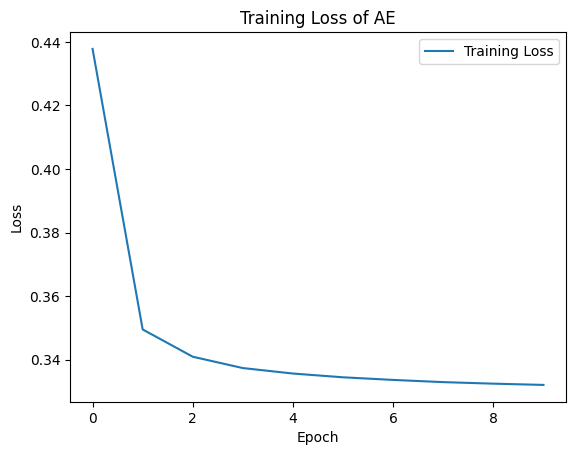

This is the trained Auto Encoder:
Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Tanh()
  )
)



In [ ]:
# Conditional model training
if is_training:
  # Load the pretrained autoencoder
  autoencoder.load_state_dict(torch.load(autoencoder_path, map_location=device))

else:
  optimizer_ae = optim.Adam(autoencoder.parameters(), lr=0.001)
  criterion_ae = nn.MSELoss()

  train_autoencoder(autoencoder, train_loader, criterion_ae, optimizer_ae, device, epochs=10)

***Tranining of the autoencoder converges***

In [ ]:
# Model converged with a good loss -> save and download the model
if not is_training:
  torch.save(autoencoder.state_dict(), autoencoder_path)
  files.download(autoencoder_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**4.3 Create trained OSR Model for Evaluation**

In [ ]:
# trained models weights are upload -> can prepare osr model
osr_model = OSR_Model(baseline_model, autoencoder)

# **5. Hyperparamter Tuning - MNIST and Reconstruction/OOD Threshold Determination**

**5.1 Determine Threshholds for MNIST on Validation Set**

In [ ]:
def determine_mnist_threshold(baseline_model, val_loader, device, percentile=1):
    baseline_model.eval()
    max_probs = []

    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            outputs, _ = baseline_model(data)
            probs = F.softmax(outputs, dim=1)
            max_prob, _ = torch.max(probs, dim=1)
            max_probs.extend(max_prob.cpu().numpy())

    # Compute threshold on for MNIST labels
    threshold_mnist = np.percentile(max_probs, percentile)
    return threshold_mnist

In [ ]:
percentile = 1
threshold_mnist = determine_mnist_threshold(baseline_model, val_loader, device, percentile=1)
print(f"Determined MNIST loss threshold: {threshold_mnist}")

Determined MNIST loss threshold: 0.6386298078298569


**5.2 Determine Threshholds for OOD/Reconstruction Error on Validation Set**

In [ ]:
def determine_reconstruction_threshold(autoencoder, val_loader, device, percentile):
    autoencoder.eval()
    errors = []
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            reconstructions = autoencoder(data)
            reconstruction_error = torch.mean((data - reconstructions) ** 2, dim=[1, 2, 3])
            errors.extend(reconstruction_error.cpu().numpy())
    threshold = np.percentile(errors, percentile)
    return threshold

In [ ]:
percentile = 99
threshold_reconstruction = determine_reconstruction_threshold(autoencoder, val_loader, device, percentile)
print(f"Determined reconstruction loss threshold: {threshold_reconstruction}")

Determined loss threshold: 0.7045428603887558


# **6. Evaluation**

**6.1 Evaluation of Baseline Model on MNIST Test Set only!**

In [ ]:
def evaluate_baseline_model(model, test_loader, device):
    model.eval() # evaluate OSR model
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient computation for faster computations
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs, _ = model(data)
            _, preds = torch.max(outputs, 1)  # Get predicted labels
            all_labels.extend(labels.cpu().numpy())  # Collect true labels
            all_preds.extend(preds.cpu().numpy())  # Collect predicted labels

    accuracy = accuracy_score(all_labels, all_preds)

    conf_matrix = confusion_matrix(all_labels, all_preds)

    return accuracy, conf_matrix

In [ ]:
accuracy_baseline_model, conf_matrix_baseline_model = evaluate_baseline_model(baseline_model, test_loader, device)

***6.2 Evaluation of OSR Model on Combined Data with determined Tresholds***

In [ ]:
def eval_osr_model(osr_model, data_loader, device, mnist_threshold, threshold_reconstruction, trials = 5):

    # Get Baseline and AE from the OSR model 
    baseline_model = osr_model.get_baseline_model()
    autoencoder = osr_model.get_autoencoder()

    # Evaluate the trained models
    baseline_model.eval()
    autoencoder.eval()

    mnist_correct, mnist_total = 0, 0
    ood_correct, ood_total = 0, 0

    all_labels, all_predictions, total_reconstruction_errors = [], [], []
    all_embeddings = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            probabilities_of_trials = []

            # several trials for more robust predictions
            for _ in range(trials):
                output, embeddings = baseline_model(inputs)
                probabilities = torch.softmax(output, dim=1)
                probabilities_of_trials.append(probabilities)

            # Average probabilities of trials
            avg_probs = torch.mean(torch.stack(probabilities_of_trials), dim=0)
            max_prob_vals, predicted_labels = torch.max(avg_probs, 1)
            predicted_labels[max_prob_vals < mnist_threshold] = 10 # classify as unknown if the mnist accuracy wasn't achieved

            # Calculate reconstruction error
            reconstructed_mnist = autoencoder(inputs) # Auto Encoder reconstructs MNIST digits
            reconstruction_error = torch.mean((inputs - reconstructed_mnist) ** 2, dim=[1, 2, 3])

            # Collect labels, predictions, and reconstruction errors
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())
            total_reconstruction_errors.extend(reconstruction_error.cpu().numpy())
            all_embeddings.extend(embeddings.cpu().numpy())

    # Convert lists to numpy arrays for summing up correct predictions
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    total_reconstruction_errors = np.array(total_reconstruction_errors)
    all_embeddings = np.array(all_embeddings)

    # Define masks for MNIST and OOD
    mnist_mask = all_labels < 10 # digits 0-9
    ood_mask = all_labels == 10  # unknown "digit"
    
    all_predictions = np.where(total_reconstruction_errors > threshold_reconstruction, 10, all_predictions) # OOD detection based on reconstruction error

    
    # Calculate MNIST correct classified labels
    mnist_correct = np.sum(all_predictions[mnist_mask] == all_labels[mnist_mask])
    mnist_total = np.sum(mnist_mask)

    # Calculate OOD correct classified labels
    ood_correct = np.sum(all_predictions[ood_mask] == 10)
    ood_total = np.sum(ood_mask)

    mnist_accuracy = mnist_correct / mnist_total if mnist_total > 0 else 0
    ood_accuracy = ood_correct / ood_total if ood_total > 0 else 0
    total_accuracy = (mnist_correct + ood_correct) / (mnist_total + ood_total)

    return mnist_accuracy, ood_accuracy, total_accuracy, all_labels, all_predictions, all_embeddings

In [ ]:
acc_mnist, acc_ood, acc_total, all_labels, all_preds, all_embeddings = eval_osr_model(osr_model, data_loader, device, threshold_mnist, threshold_reconstruction)

# **7. Plots of Results**

***7.1 Baseline Model on MNIST Test Set***

***7.1.1 Accuracy***

In [ ]:
print(f"Baseline Model Accuracy on MNIST Test Set: {accuracy_baseline_model * 100:.2f}%\n")

Baseline Model Accuracy on MNIST Test Set: 98.46%



***7.1.2 Confusion Matrix***

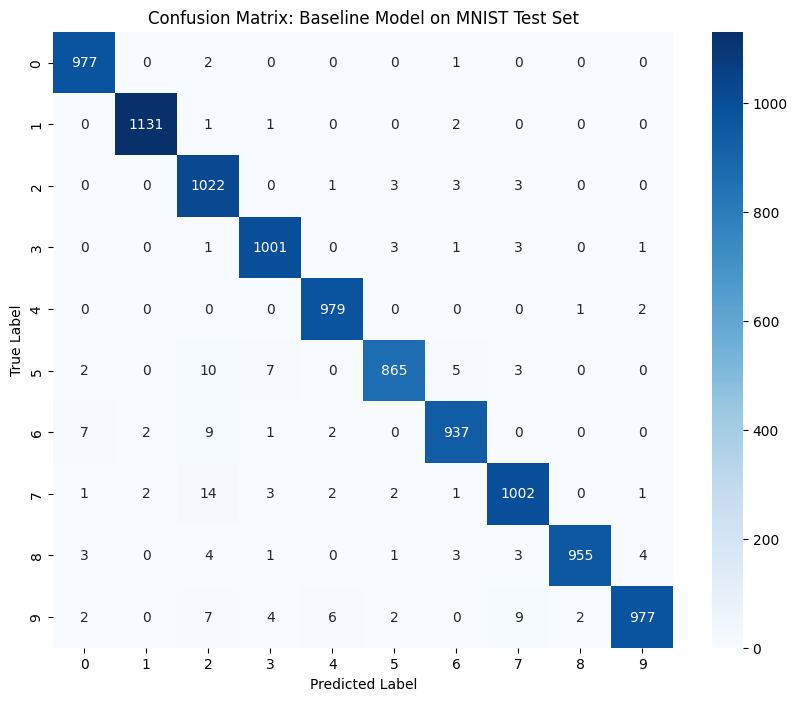

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_baseline_model, annot=True, fmt="d", cmap="Blues",
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.title("Confusion Matrix: Baseline Model on MNIST Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

***7.2 OSR Model on Binary Data (Known vs. Unknown)***

***7.2.1 Accuracy***

In [ ]:
# Binary confusion matrix: Known (0) vs. Unknown (1)
binary_labels = np.where(all_labels < 10, 0, 1)
binary_preds = np.where(all_preds < 10, 0, 1)
binary_conf_matrix = confusion_matrix(binary_labels, binary_preds)
# Extract values from confusion matrix for binary-accuracy calculation 
tn, fp, fn, tp = binary_conf_matrix.ravel()

# Calculate binary accuracy
binary_accuracy = (tp + tn) / (tn + fp + fn + tp)
print(f'Binary Accuracy: {binary_accuracy * 100:.2f}%')

Binary Accuracy: 97.32%


***7.2.2 Confusion Matrix***

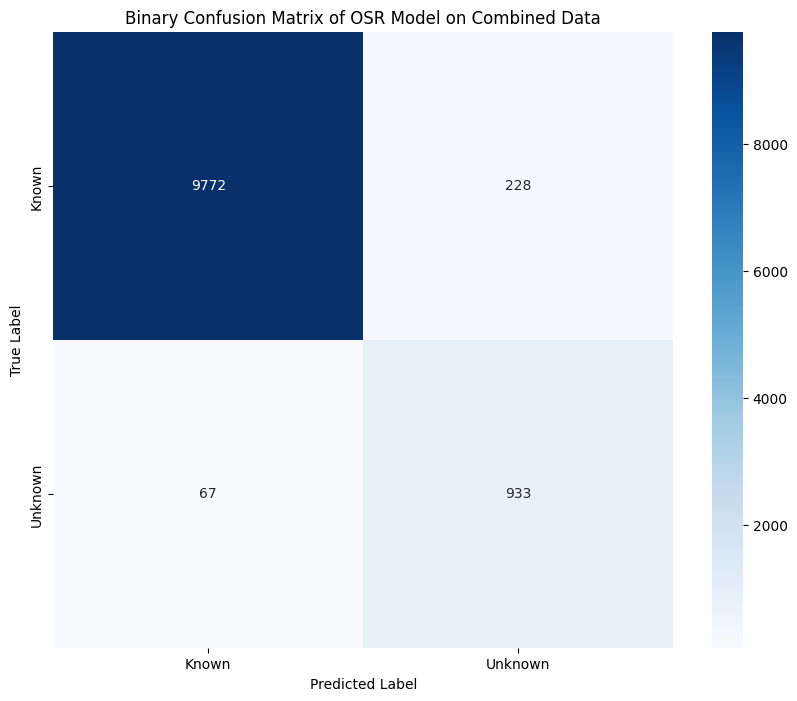

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(binary_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Known', 'Unknown'], yticklabels=['Known', 'Unknown'])
plt.title('Binary Confusion Matrix of OSR Model on Combined Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

***7.3 OSR Model on total-Combined Data***

***7.3.1 Accuracies***

In [ ]:
print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%')
print(f'Total Accuracy: {acc_total*100:.2f}%\n')


MNIST Accuracy: 96.43%
OOD Accuracy: 93.30%
Total Accuracy: 96.15%



***7.3.2 Confusion Matrix***

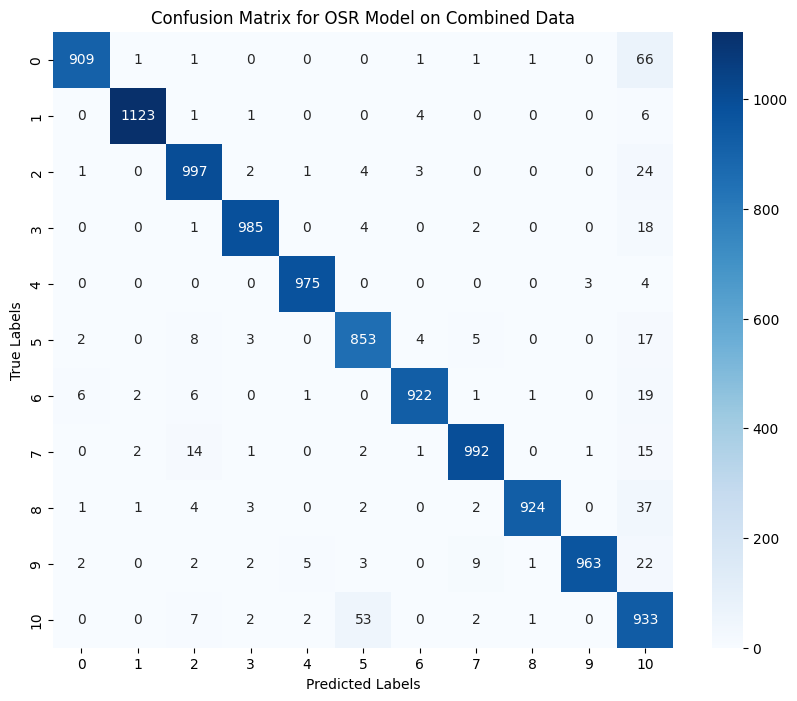

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(11)), yticklabels=list(range(11)))
plt.title('Confusion Matrix for OSR Model on Combined Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

***7.4 tSNE of OSR Model on Combined Data***

In [ ]:
def visualize_embeddings(embeddings, labels, method='tsne'):
    if method == 'tsne':
        tsne = TSNE(n_components=2, random_state=42)
        reduced_data = tsne.fit_transform(embeddings)
    elif method == 'pca':
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(embeddings)

    # black as color for the unknown class
    cmap = mcolors.ListedColormap(['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
                                   'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray',
                                   'tab:olive', 'tab:cyan', 'black'])

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap=cmap)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(f'{method.upper()} Visualization of Embeddings for all 11 Classes')
    plt.show()

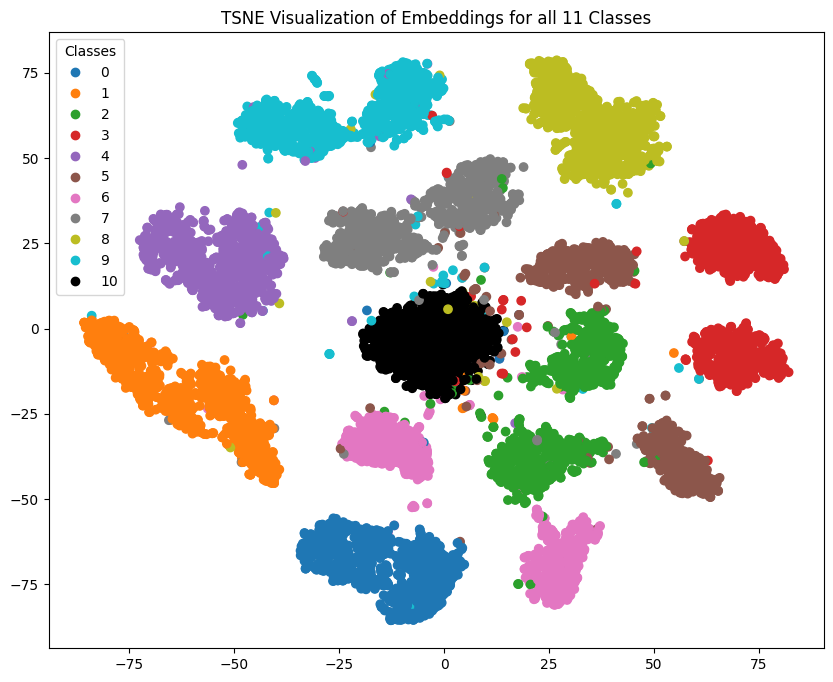

In [ ]:
visualize_embeddings(all_embeddings, all_labels, method='tsne')

***7.5 PCA of OSR Model on Combined Data***

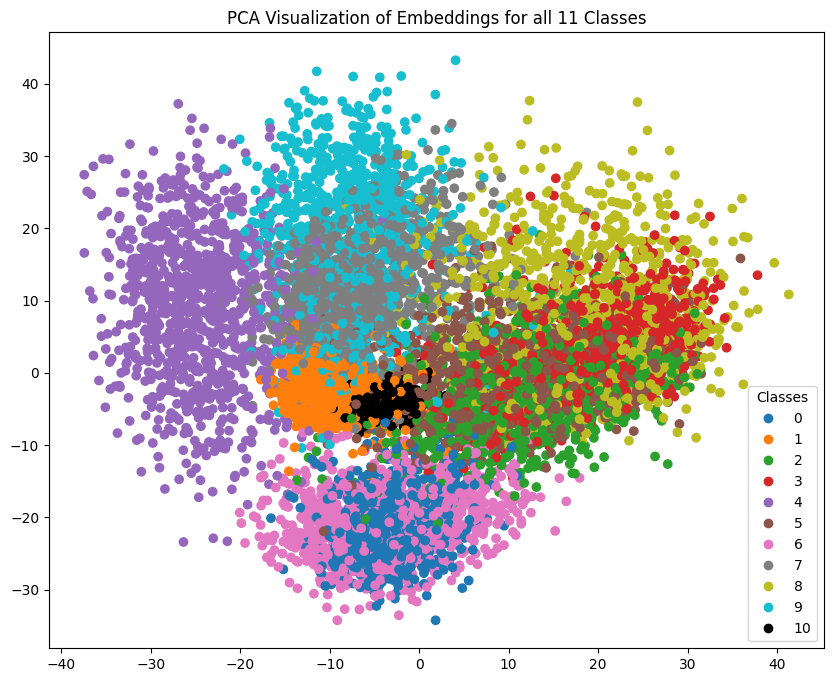

In [ ]:
visualize_embeddings(all_embeddings, all_labels, method='pca')

***7.6 ROC Curve of OSR Model on Binary-Data***


In [ ]:
def plot_roc_curve(all_labels, all_preds):
    fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

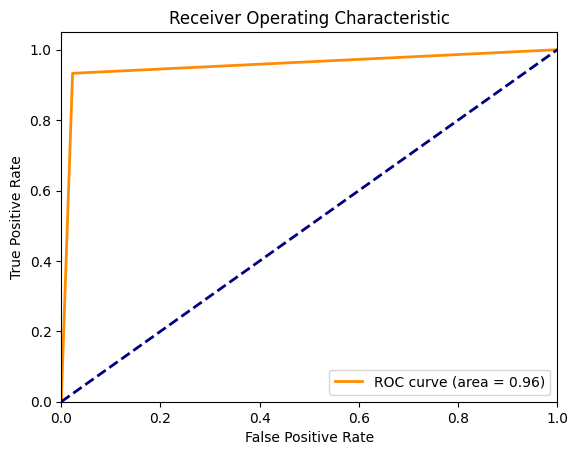

In [ ]:
plot_roc_curve(binary_labels, binary_preds)